In [2]:
import numpy as np
import Euclid
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, Column
import shutil
from tqdm.notebook import tqdm
import numpy.lib.recfunctions as rfn

%elogin
%erun Elements 5.10

sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/python/')

%load_ext autoreload
%autoreload 2
from nnpz.reference_sample.ReferenceSample import ReferenceSample
from nnpz.photometry.DirectoryFilterProvider import DirectoryFilterProvider

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
filter_provider = DirectoryFilterProvider('/home/aalvarez/Phosphoros/AuxiliaryData/Filters/')

bands = [
    'u','g','r','i','z',
    'vis', 'Y','J','H']
fbands = [
    'kids/u', 'des/g', 'des/r', 'des/i', 'des/z',
    'euclid/VIS', 'euclid/Y', 'euclid/J', 'euclid/H'
]

# Load data

In [50]:
ophoto = np.load('/home/aalvarez/Work/Data/WillPP/photometry_data_0.npy', mmap_mode='r')
opdz = np.load('/home/aalvarez/Work/Data/WillPP/pdz_data_0.npy', mmap_mode='r')
opp_samples = np.load('/home/aalvarez/Work/Data/WillPP/mc_data_0.npy', mmap_mode='r')
pdz_bins = opdz[0]
opdz = opdz[1:]

In [51]:
oids = np.arange(len(ophoto))
len(oids)

22327

# Filter -99, invalid fluxes, etc

In [52]:
mask = np.full(len(oids), True)
print('All', mask.sum())

# Fluxes
for i in range(len(bands)):
    mask = mask & (ophoto['Flux'][:,i] >= 0)
    mask = mask & (ophoto['Flux'][:,i] / ophoto['Flux_err'][:,i] >= 10)
print('Print good fluxes', mask.sum())
    
# -99 Z
mask = mask & (opp_samples['Z'][:,0] >= 0)
print('Good Z', mask.sum())

ids = oids[mask]
photo = ophoto[mask]
pdz = opdz[mask]
pp_samples = opp_samples[mask]

All 22327
Print good fluxes 5268
Good Z 5266


In [53]:
assert len(ids) == len(photo)
assert len(pdz) == len(photo)
assert len(pp_samples) == len(photo)

In [54]:
diff = []
for i in range(len(ids)):
    diff.append(pp_samples['Z'][i,0] - pdz_bins[pdz[i].argmax()])
np.min(diff), np.max(diff)

(-0.16260003566741954, 0.1697999763488771)

1.8323999643325806


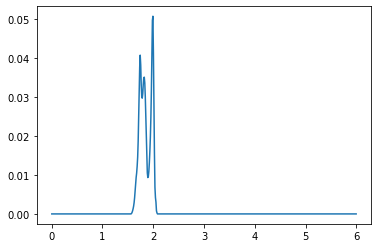

In [55]:
print(pp_samples['Z'][np.argmin(diff),0])
plt.figure()
plt.plot(pdz_bins, pdz[np.argmin(diff)])

Bueno, los peores son bimodales, y el valor Z es la media, es de esperar.

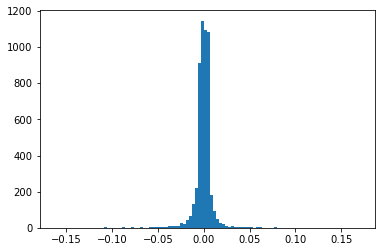

In [56]:
plt.figure()
plt.hist(diff, bins=100)
plt.show()

# Photometry

In [57]:
columns = [
    Column(ids, name='ID', dtype=np.int),
    Column(pp_samples['Z'][:,0], 'Z')
]

for i, f in enumerate(bands):
    columns.append(Column(photo['Flux'][:,i], name=f'{f}_obs'))
    columns.append(Column(photo['Flux_err'][:,i], name=f'{f}_obs_err'))
    
table = Table(columns)
len(table)

5266

In [58]:
idx = np.arange(len(table))
np.random.shuffle(idx)
nref = int(len(idx) * 0.9)
ref_idx = idx[:nref]
target_idx = idx[nref:]

In [59]:
ref_hdus = fits.HDUList([fits.PrimaryHDU(), fits.BinTableHDU(table[ref_idx], name='NNPZ_PHOTOMETRY')])

for f, ftrans in zip(bands, fbands):
    trans = filter_provider.getFilterTransmission(ftrans)
    trans_col_data = [
        table.Column(trans[:, 0]),
        table.Column(trans[:, 1])
    ]
    ref_hdus.append(fits.BinTableHDU(
        Table(trans_col_data, names=['Wavelength', 'Transmission']),
        name=f'{f}_obs'
    ))

ref_hdus.writeto('/home/aalvarez/Work/Data/WillPP/Reference.fits', overwrite=True)

In [60]:
table[target_idx].write('/home/aalvarez/Work/Data/WillPP/Target.fits', overwrite=True)

# Generate full ref sample

In [61]:
try:
    shutil.rmtree('/home/aalvarez/Work/Data/WillPP/ReferenceSample')
except:
    pass

ref = ReferenceSample.createNew('/home/aalvarez/Work/Data/WillPP/ReferenceSample')
for i in tqdm(ref_idx):
    oid = table['ID'][i]
    ref.addPdzData(oid, np.stack([pdz_bins, pdz[i]], axis=-1))

INFO    : Found provider PdzProvider
2020-10-30T10:59:25CET ReferenceSample  INFO : Found provider PdzProvider
INFO    : Found provider SedProvider
2020-10-30T10:59:25CET ReferenceSample  INFO : Found provider SedProvider


In [62]:
oids = table['ID'][ref_idx]
ref.addProvider('MontecarloProvider', 'pp', 'pp_data_{}.npy', oids, pp_samples[ref_idx])

In [63]:
ref.flush()

In [65]:
diff = []
idxs = []
for oid in tqdm(ref.getIds()):
    idx = np.where(ids == oid)[0][0]
    diff.append(pp_samples['Z'][idx,0] - pdz_bins[ref.getPdzData(oid)[:,1].argmax()])
    idxs.append(idx)

In [66]:
np.min(diff), np.max(diff)

(-0.16260003566741954, 0.1697999763488771)

1.364799976348877
1.1949999999999998


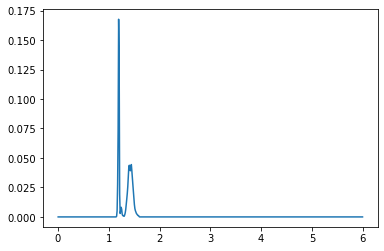

In [67]:
midx = idxs[np.argmax(diff)]
print(pp_samples['Z'][midx,0])
print(pdz_bins[pdz[midx].argmax()])
plt.figure()
plt.plot(pdz_bins, pdz[midx])

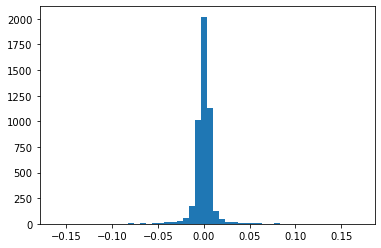

In [68]:
plt.figure()
plt.hist(diff, bins=50)
plt.show()